In [1]:
conda init

no change     /Users/aesthetic/opt/anaconda3/condabin/conda
no change     /Users/aesthetic/opt/anaconda3/bin/conda
no change     /Users/aesthetic/opt/anaconda3/bin/conda-env
no change     /Users/aesthetic/opt/anaconda3/bin/activate
no change     /Users/aesthetic/opt/anaconda3/bin/deactivate
no change     /Users/aesthetic/opt/anaconda3/etc/profile.d/conda.sh
no change     /Users/aesthetic/opt/anaconda3/etc/fish/conf.d/conda.fish
no change     /Users/aesthetic/opt/anaconda3/shell/condabin/Conda.psm1
no change     /Users/aesthetic/opt/anaconda3/shell/condabin/conda-hook.ps1
no change     /Users/aesthetic/opt/anaconda3/lib/python3.8/site-packages/xontrib/conda.xsh
no change     /Users/aesthetic/opt/anaconda3/etc/profile.d/conda.csh
no change     /Users/aesthetic/.bash_profile
No action taken.

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install alpha_vantage pandas


Note: you may need to restart the kernel to use updated packages.


In [3]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from alpha_vantage.techindicators import TechIndicators
from datetime import date
from datetime import timedelta

import matplotlib.pyplot as plt 
import sys
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report


import numpy as np



In [4]:
# Obtaining stock data from alpha vantage 
sym='AAPL'

date_of_data='2010-01-01'


ticker_list=['MS', 'BT-A.L', 'TSLA', 'PFE' ]
# 'BT-A.L', 'TSLA', 'PFE'
column_names=['1. open', '2. high', '3. low', '4. close', '5. adjusted close', '6. volume', 
               '7. dividend amount', '8. split coefficient', 'Ticker']
#obtains stock data from the previous day date to 2018-11-29


def stock_data(sym):
    ts = TimeSeries(key='SUXOFAIGXM6HEP9Y', output_format='pandas')
    data, meta_data = ts.get_daily_adjusted(symbol=sym, outputsize='full')
    data_date_changed = data[:date_of_data]
    data_date_changed['Ticker']= sym
    return data_date_changed


data_dated = pd.DataFrame(columns = column_names)


# for ticker in ticker_list:
#     data_dated = data_dated.append(stock_data(ticker), sort=False)


In [5]:
data_dated= stock_data(sym)

<ipython-input-4-3cee4db88d77>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_date_changed['Ticker']= sym


# Identify Anomalies

In [6]:
print('The shape of our data is:', data_dated.shape)

The shape of our data is: (2811, 9)


In [7]:
data_dated.isna().any()

1. open                 False
2. high                 False
3. low                  False
4. close                False
5. adjusted close       False
6. volume               False
7. dividend amount      False
8. split coefficient    False
Ticker                  False
dtype: bool

In [8]:
data_dated.tail()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker
date,,,,,,,,,
2010-01-08,210.30,212.00,209.06,211.98,6.520297,15986100.0,0.0,1.0,AAPL
2010-01-07,211.75,212.00,209.05,210.58,6.477234,17040400.0,0.0,1.0,AAPL
2010-01-06,214.38,215.23,210.75,210.97,6.489230,19720000.0,0.0,1.0,AAPL
2010-01-05,214.60,215.59,213.25,214.38,6.594118,21496600.0,0.0,1.0,AAPL
2010-01-04,213.43,214.50,212.38,214.01,6.582737,17633200.0,0.0,1.0,AAPL


In [9]:

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

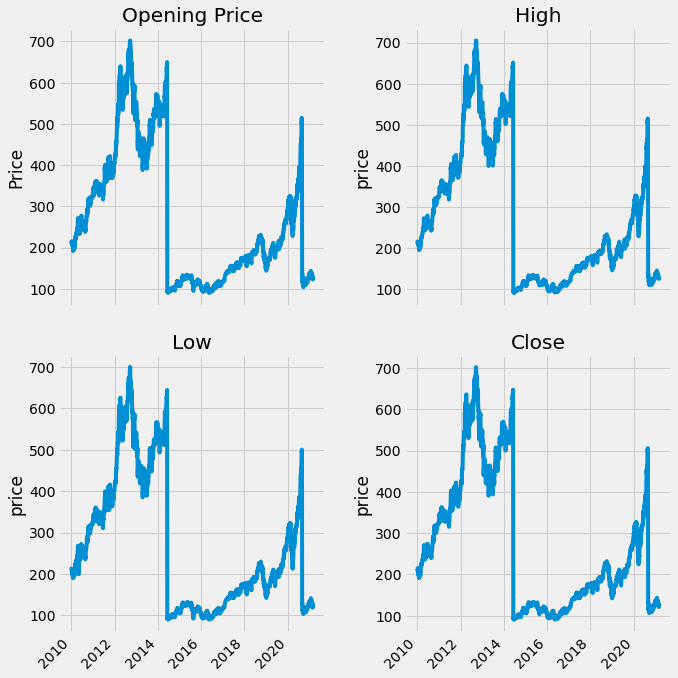

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# opening price
ax1.plot(data_dated.index, data_dated['1. open'])
ax1.set_xlabel(''); ax1.set_ylabel('Price'); ax1.set_title('Opening Price')


ax2.plot(data_dated.index, data_dated['2. high'])
ax2.set_xlabel(''); ax2.set_ylabel('price'); ax2.set_title('High')


ax3.plot(data_dated.index, data_dated['3. low'])
ax3.set_xlabel(''); ax3.set_ylabel('price'); ax3.set_title('Low')

ax4.plot(data_dated.index, data_dated['4. close'])
ax4.set_xlabel(''); ax4.set_ylabel('price'); ax4.set_title('Close')


plt.tight_layout(pad=2)


In [11]:
data_dated[data_dated.duplicated()]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker
date,,,,,,,,,


One Hot Encoding 

# data_dated.tail()

In [12]:
def trading_window(data):
  
  # 1 day window 
  n = 90

  # Create a column containing the prices for the next 1 days
  data['change_in_price'] = data[['4. close']].shift(-n)
  
  # return the new dataset 
  return data

In [13]:
# data_dated.reset_index(inplace = True) 
data_dated.sort_index(inplace=True)
# data_dated.sort_values(by = ['Ticker','date'], inplace = True)


# sort the values by symbol and then date


# calculate the change in price
data_dated['change_in_price'] = data_dated['4. close'].diff()

# data_dated['change_in_price']= data_dated['4. close'].diff()

In [14]:
mask = data_dated['Ticker'] != data_dated['Ticker'].shift(1)

data_dated['change_in_price']= np.where(mask==True, np.nan, data_dated['change_in_price'])

data_dated[data_dated.isna().any(axis=1)]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,change_in_price
date,,,,,,,,,,
2010-01-04,213.43,214.5,212.38,214.01,6.582737,17633200.0,0.0,1.0,AAPL,NaN


In [15]:
# data_dated.reset_index(inplace=True)

In [16]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = data_dated[['Ticker','change_in_price']].copy(), data_dated[['Ticker','change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
data_dated['down_days'] = down_df['change_in_price']
data_dated['up_days'] = up_df['change_in_price']
data_dated['RSI'] = relative_strength_index

# Display the head.
data_dated.head(30)

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,change_in_price,down_days,up_days,RSI
date,,,,,,,,,,,,,
2010-01-04,213.430,214.5000,212.380,214.010,6.582737,17633200.0,0.0,1.0,AAPL,NaN,NaN,NaN,NaN
2010-01-05,214.600,215.5900,213.250,214.380,6.594118,21496600.0,0.0,1.0,AAPL,0.370,0.000,0.370,100.000000
2010-01-06,214.380,215.2300,210.750,210.970,6.489230,19720000.0,0.0,1.0,AAPL,-3.410,3.410,0.000,8.595425
2010-01-07,211.750,212.0000,209.050,210.580,6.477234,17040400.0,0.0,1.0,AAPL,-0.390,0.390,0.000,7.670228
2010-01-08,210.300,212.0000,209.060,211.980,6.520297,15986100.0,0.0,1.0,AAPL,1.400,0.000,1.400,36.141053
2010-01-11,212.800,213.0000,208.450,210.110,6.462777,16508200.0,0.0,1.0,AAPL,-1.870,1.870,0.000,24.498300
2010-01-12,209.190,209.7700,206.420,207.720,6.389263,21230700.0,0.0,1.0,AAPL,-2.390,2.390,0.000,16.608210
2010-01-13,207.870,210.9300,204.100,210.650,6.479387,21639000.0,0.0,1.0,AAPL,2.930,0.000,2.930,42.708850
2010-01-14,210.110,210.4600,209.020,209.430,6.441861,15460500.0,0.0,1.0,AAPL,-1.220,1.220,0.000,37.126110


In [17]:
# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = data_dated[['Ticker','3. low']].copy(), data_dated[['Ticker','2. high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('Ticker')['3. low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['2. high'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((data_dated['4. close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
data_dated['low_14'] = low_14
data_dated['high_14'] = high_14
data_dated['k_percent'] = k_percent

# Display the head.
data_dated.head(5)

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
date,,,,,,,,,,,,,,,,
2010-01-04,213.43,214.50,212.38,214.01,6.582737,17633200.0,0.0,1.0,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,214.60,215.59,213.25,214.38,6.594118,21496600.0,0.0,1.0,AAPL,0.37,0.00,0.37,100.000000,NaN,NaN,NaN
2010-01-06,214.38,215.23,210.75,210.97,6.489230,19720000.0,0.0,1.0,AAPL,-3.41,3.41,0.00,8.595425,NaN,NaN,NaN
2010-01-07,211.75,212.00,209.05,210.58,6.477234,17040400.0,0.0,1.0,AAPL,-0.39,0.39,0.00,7.670228,NaN,NaN,NaN
2010-01-08,210.30,212.00,209.06,211.98,6.520297,15986100.0,0.0,1.0,AAPL,1.40,0.00,1.40,36.141053,NaN,NaN,NaN


In [18]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = data_dated[['Ticker','3. low']].copy(), data_dated[['Ticker','2. high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('Ticker')['3. low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['2. high'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - data_dated['4. close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
data_dated['r_percent'] = r_percent

# Display the head.
data_dated.head(5)

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
date,,,,,,,,,,,,,,,,,
2010-01-04,213.43,214.50,212.38,214.01,6.582737,17633200.0,0.0,1.0,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,214.60,215.59,213.25,214.38,6.594118,21496600.0,0.0,1.0,AAPL,0.37,0.00,0.37,100.000000,NaN,NaN,NaN,NaN
2010-01-06,214.38,215.23,210.75,210.97,6.489230,19720000.0,0.0,1.0,AAPL,-3.41,3.41,0.00,8.595425,NaN,NaN,NaN,NaN
2010-01-07,211.75,212.00,209.05,210.58,6.477234,17040400.0,0.0,1.0,AAPL,-0.39,0.39,0.00,7.670228,NaN,NaN,NaN,NaN
2010-01-08,210.30,212.00,209.06,211.98,6.520297,15986100.0,0.0,1.0,AAPL,1.40,0.00,1.40,36.141053,NaN,NaN,NaN,NaN


In [19]:
# Calculate the MACD
ema_26 = data_dated.groupby('Ticker')['4. close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = data_dated.groupby('Ticker')['4. close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
data_dated['MACD'] = macd
data_dated['MACD_EMA'] = ema_9_macd

# Print the head.
data_dated.head(5)

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
date,,,,,,,,,,,,,,,,,,,
2010-01-04,213.43,214.50,212.38,214.01,6.582737,17633200.0,0.0,1.0,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2010-01-05,214.60,215.59,213.25,214.38,6.594118,21496600.0,0.0,1.0,AAPL,0.37,0.00,0.37,100.000000,NaN,NaN,NaN,NaN,0.008301,0.004612
2010-01-06,214.38,215.23,210.75,210.97,6.489230,19720000.0,0.0,1.0,AAPL,-3.41,3.41,0.00,8.595425,NaN,NaN,NaN,NaN,-0.095166,-0.036281
2010-01-07,211.75,212.00,209.05,210.58,6.477234,17040400.0,0.0,1.0,AAPL,-0.39,0.39,0.00,7.670228,NaN,NaN,NaN,NaN,-0.153974,-0.076150
2010-01-08,210.30,212.00,209.06,211.98,6.520297,15986100.0,0.0,1.0,AAPL,1.40,0.00,1.40,36.141053,NaN,NaN,NaN,NaN,-0.126979,-0.091270


In [20]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
data_dated['Price_Rate_Of_Change'] = data_dated.groupby('Ticker')['4. close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
data_dated.head(5)

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
date,,,,,,,,,,,,,,,,,,,,
2010-01-04,213.43,214.50,212.38,214.01,6.582737,17633200.0,0.0,1.0,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2010-01-05,214.60,215.59,213.25,214.38,6.594118,21496600.0,0.0,1.0,AAPL,0.37,0.00,0.37,100.000000,NaN,NaN,NaN,NaN,0.008301,0.004612,NaN
2010-01-06,214.38,215.23,210.75,210.97,6.489230,19720000.0,0.0,1.0,AAPL,-3.41,3.41,0.00,8.595425,NaN,NaN,NaN,NaN,-0.095166,-0.036281,NaN
2010-01-07,211.75,212.00,209.05,210.58,6.477234,17040400.0,0.0,1.0,AAPL,-0.39,0.39,0.00,7.670228,NaN,NaN,NaN,NaN,-0.153974,-0.076150,NaN
2010-01-08,210.30,212.00,209.06,211.98,6.520297,15986100.0,0.0,1.0,AAPL,1.40,0.00,1.40,36.141053,NaN,NaN,NaN,NaN,-0.126979,-0.091270,NaN


In [21]:
# Create a column we wish to predict
'''
    In this case, let's create an output column that will be 1 if the closing price at time 't' is greater than 't-1' and 0 otherwise.
    In other words, if the today's closing price is greater than yesterday's closing price it would be 1.
'''

# Group by the `Symbol` column, then grab the `Close` column.
close_groups = data_dated.groupby('Ticker')['4. close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
data_dated['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
data_dated.loc[data_dated['Prediction'] == 0.0] = 1.0

# print the head
data_dated.head(5)

# OPTIONAL CODE: Dump the data frame to a CSV file to examine the data yourself.
# price_data.to_csv('final_metrics.csv')

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,change_in_price,...,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,Prediction
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,213.43,214.50,212.38,214.01,6.582737,17633200.0,0.0,1.0,AAPL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
2010-01-05,214.60,215.59,213.25,214.38,6.594118,21496600.0,0.0,1.0,AAPL,0.37,...,0.37,100.000000,NaN,NaN,NaN,NaN,0.008301,0.004612,NaN,1.0
2010-01-06,214.38,215.23,210.75,210.97,6.489230,19720000.0,0.0,1.0,AAPL,-3.41,...,0.00,8.595425,NaN,NaN,NaN,NaN,-0.095166,-0.036281,NaN,-1.0
2010-01-07,211.75,212.00,209.05,210.58,6.477234,17040400.0,0.0,1.0,AAPL,-0.39,...,0.00,7.670228,NaN,NaN,NaN,NaN,-0.153974,-0.076150,NaN,-1.0
2010-01-08,210.30,212.00,209.06,211.98,6.520297,15986100.0,0.0,1.0,AAPL,1.40,...,1.40,36.141053,NaN,NaN,NaN,NaN,-0.126979,-0.091270,NaN,1.0


In [22]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(data_dated.shape[0], data_dated.shape[1]))

# Any row that has a `NaN` value will be dropped.
data_dated = data_dated.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(data_dated.shape[0], data_dated.shape[1]))

# Print the head.
data_dated.head()

Before NaN Drop we have 2811 rows and 21 columns
After NaN Drop we have 2798 rows and 21 columns


,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,change_in_price,...,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,Prediction
date,,,,,,,,,,,,,,,,,,,,,
2010-01-22,206.78,207.50,197.160,197.750,6.082596,31491700.0,0.0,1.0,AAPL,-10.322,...,0.000,26.803255,197.16,215.59,3.201302,-96.798698,-0.919541,-0.362312,-0.067129,-1.0
2010-01-25,202.51,204.70,200.190,203.075,6.246388,38060700.0,0.0,1.0,AAPL,5.325,...,5.325,39.805069,197.16,215.59,32.094411,-67.905589,-1.123743,-0.520152,-0.033482,1.0
2010-01-26,205.95,213.71,202.580,205.940,6.334512,66682500.0,0.0,1.0,AAPL,2.865,...,2.865,45.783616,197.16,215.55,47.743339,-52.256661,-1.090805,-0.637588,-0.008569,1.0
2010-01-27,206.85,210.58,199.531,207.884,6.394308,61520300.0,0.0,1.0,AAPL,1.944,...,1.944,49.695300,197.16,215.55,58.314301,-41.685699,-0.931845,-0.697795,-0.013131,1.0
2010-01-28,204.93,205.50,198.700,199.290,6.129965,41910800.0,0.0,1.0,AAPL,-8.594,...,0.000,36.326244,197.16,215.55,11.582382,-88.417618,-1.340518,-0.828698,-0.048417,-1.0


In [24]:
# Grab our X & Y Columns.
X_Cols = data_dated[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD']]
Y_Cols = data_dated['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [25]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  71.14285714285714


In [26]:
y_pred[5]

-1.0

In [27]:
y_test.head(5)

date
2015-07-31   -1.0
2010-11-01    1.0
2011-01-24    1.0
2020-04-30    1.0
2014-03-17    1.0
Name: Prediction, dtype: float64

In [28]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.685950,0.738872,0.711429,337.000000
Up Day,0.738872,0.685950,0.711429,363.000000
accuracy,0.711429,0.711429,0.711429,0.711429
macro avg,0.712411,0.712411,0.711429,700.000000
weighted avg,0.713394,0.711429,0.711429,700.000000


Accuracy: 0.7114285714285714
Percision: 0.7388724035608308
Recall: 0.6859504132231405
Specificity: 0.7388724035608308


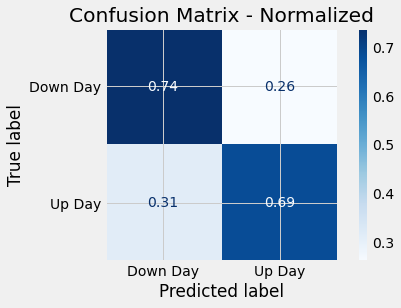

In [29]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(rand_frst_clf, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

In [30]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

r_percent               0.235835
k_percent               0.211977
RSI                     0.197471
Price_Rate_Of_Change    0.178267
MACD                    0.176450
dtype: float64

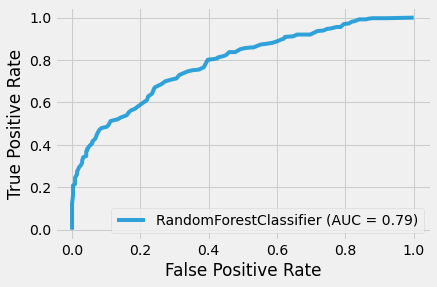

In [31]:
# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(rand_frst_clf, X_test, y_test, alpha = 0.8)
plt.show()

In [32]:


5- 66.47727272727273

30-  64.75095785440614

90- 67

23